In [12]:
import os
import sys
import pandas as pd
import numpy as np
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

#sklearns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


In [13]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

START BY PREPARING EACH DATASET FOR TRAINING


In [14]:
ravdess = './dataset/RAVDESS/' #in folders
crema = './dataset/CREMAD/' # direct files
tess = './dataset/TESS/' #in folders
savee = './dataset/SAVEE/' #in folders

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [15]:
## RAVDESS DATAFRAME

In [16]:
ravdess_dir_list = os.listdir(ravdess)

file_emotion = []
file_path = []
for dir in ravdess_dir_list:
    print(dir)
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    if not dir.startswith('.'):
        actor = os.listdir(ravdess + dir)
        for file in actor:
            if not file.startswith('.'): #add a check for .DS_Store and other hidden file
                part = file.split('.')[0]
                part = part.split('-')
                # third part in each file represents the emotion associated to that file.
                file_emotion.append(int(part[2]))
                file_path.append(ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(10)


Actor_16
Actor_11
Actor_18
Actor_20
Actor_21
Actor_19
Actor_10
Actor_17
.DS_Store
Actor_04
Actor_03
Actor_02
Actor_05
Actor_12
Actor_15
Actor_23
Actor_24
Actor_22
Actor_14
Actor_13
Actor_09
Actor_07
Actor_06
Actor_01
Actor_08


Emotions                                               Path
0     angry  ./dataset/RAVDESS/Actor_16/03-01-05-01-02-01-1...
1      fear  ./dataset/RAVDESS/Actor_16/03-01-06-01-02-02-1...
2      fear  ./dataset/RAVDESS/Actor_16/03-01-06-02-01-02-1...
3     angry  ./dataset/RAVDESS/Actor_16/03-01-05-02-01-01-1...
4   disgust  ./dataset/RAVDESS/Actor_16/03-01-07-01-01-01-1...
5       sad  ./dataset/RAVDESS/Actor_16/03-01-04-01-01-02-1...
6       sad  ./dataset/RAVDESS/Actor_16/03-01-04-02-02-02-1...
7   disgust  ./dataset/RAVDESS/Actor_16/03-01-07-02-02-01-1...
8  surprise  ./dataset/RAVDESS/Actor_16/03-01-08-02-02-01-1...
9  surprise  ./dataset/RAVDESS/Actor_16/03-01-08-01-01-01-1...

SAVEE Dataset

In [17]:
crema_dir_list = os.listdir(crema)
file_emotion = []
file_path = []

for file in crema_dir_list:
    if not file.startswith('.'):
        # storing file paths
        file_path.append(crema + file)
        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                  Path
0    angry  ./dataset/CREMAD/1022_ITS_ANG_XX.wav
1    angry  ./dataset/CREMAD/1037_ITS_ANG_XX.wav
2  neutral  ./dataset/CREMAD/1060_ITS_NEU_XX.wav
3  neutral  ./dataset/CREMAD/1075_ITS_NEU_XX.wav
4  disgust  ./dataset/CREMAD/1073_IOM_DIS_XX.wav

TESS DATASET

In [18]:
tess_dir_list = os.listdir(tess)

file_emotion = []
file_path = []

for dir in tess_dir_list:
    if not dir.startswith('.'):
        directories = os.listdir(tess + dir)
        for file in directories:
            if not file.startswith('.'):
                part = file.split('.')[0]
                part = part.split('_')[2]
                if part=='ps':
                    file_emotion.append('surprise')
                else:
                    file_emotion.append(part)
                file_path.append(tess + dir + '/' + file)
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                              Path
0  disgust   ./dataset/TESS/YAF_disgust/YAF_date_disgust.wav
1  disgust    ./dataset/TESS/YAF_disgust/YAF_rag_disgust.wav
2  disgust  ./dataset/TESS/YAF_disgust/YAF_raise_disgust.wav
3  disgust  ./dataset/TESS/YAF_disgust/YAF_ditch_disgust.wav
4  disgust   ./dataset/TESS/YAF_disgust/YAF_door_disgust.wav

In [19]:
savee_dir_list = os.listdir(savee)

file_emotion = []
file_path = []

for dir in savee_dir_list:
    if dir != 'Info.txt' and not dir.startswith('.'):
        directories = os.listdir(savee + dir)
        for file in directories:
            path = savee + dir + '/'+ file
            file_path.append(path)
            filename = file.split('.')[0]
            emo = list(filename)[0] # return one letter
            if emo=='a':
                file_emotion.append('angry')
            elif emo=='d':
                file_emotion.append('disgust')
            elif emo=='f':
                file_emotion.append('fear')
            elif emo=='h':
                file_emotion.append('happy')
            elif emo=='n':
                file_emotion.append('neutral')
            elif emo=='s':
                if list(filename)[1] == 'a':
                    file_emotion.append('sad')
                elif list(filename)[1] == 'u':
                    file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                         Path
0  neutral   ./dataset/SAVEE/KL/n17.wav
1  neutral   ./dataset/SAVEE/KL/n03.wav
2    happy   ./dataset/SAVEE/KL/h05.wav
3      sad  ./dataset/SAVEE/KL/sa04.wav
4    happy   ./dataset/SAVEE/KL/h11.wav

In [20]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  ./dataset/RAVDESS/Actor_16/03-01-05-01-02-01-1...
1     fear  ./dataset/RAVDESS/Actor_16/03-01-06-01-02-02-1...
2     fear  ./dataset/RAVDESS/Actor_16/03-01-06-02-01-02-1...
3    angry  ./dataset/RAVDESS/Actor_16/03-01-05-02-01-01-1...
4  disgust  ./dataset/RAVDESS/Actor_16/03-01-07-01-01-01-1...

/Users/erickhartawan/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


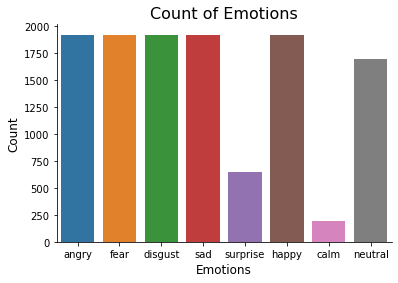

In [21]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [22]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

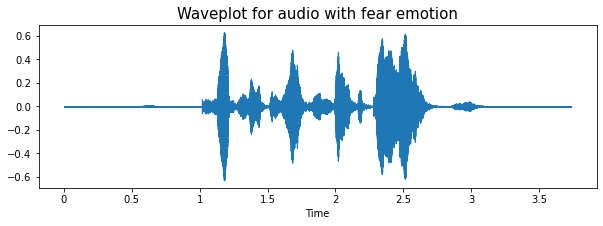

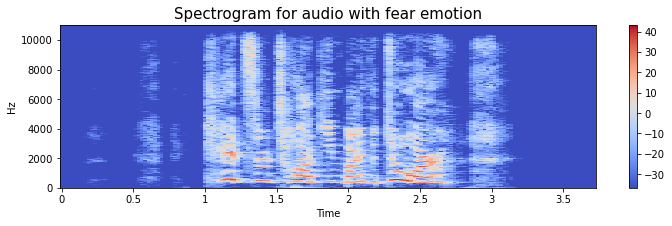

In [23]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [24]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [25]:
def extract_features(data):
    # ZCR - Frequency of the audio file
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value - average loudness level of the signal
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # Tempo of the audio
    # oenv = librosa.onset.onset_strength(y=data, sr=sample_rate, hop_length=512)
    # times = librosa.times_like(oenv, sr=sample_rate, hop_length=512)
    # tempogram = np.mean(librosa.feature.tempogram(onset_envelope=oenv, sr=sample_rate,
    #                                   hop_length=512),axis=0)
    # result = np.hstack((result,tempogram))
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching
    # new_data = stretch(data)
    # data_pitch = pitch(data, sample_rate)
    # res3 = extract_features(data_pitch)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [26]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/var/folders/z7/pm7hztvs2xzb1f0t50gtnqzc0000gn/T/ipykernel_9673/227413437.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
/var/folders/z7/pm7hztvs2xzb1f0t50gtnqzc0000gn/T/ipykernel_9673/227413437.py:14: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
/var/folders/z7/pm7hztvs2xzb1f0t50gtnqzc0000gn/T/ipykernel_9673/227413437.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
/var/folders/z7/pm7hztvs2xzb1f0t50gtnqzc0000gn/T/ipykernel_9673/227413437.py:14: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments 

In [27]:
word = ''
for i in range(1,167):
    word = word + str(i) + ','
print(word)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,


In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features_notempo.csv', index=False)
Features.head(15)

0         1         2         3         4         5         6  \
0   0.192464  0.516620  0.464575  0.484971  0.538362  0.500001  0.598386   
1   0.311596  0.630695  0.637181  0.671804  0.648783  0.676894  0.623250   
2   0.222465  0.623192  0.508885  0.473313  0.479617  0.492326  0.520755   
3   0.184814  0.552939  0.514264  0.477355  0.408057  0.359502  0.394911   
4   0.310009  0.732260  0.733525  0.714867  0.663606  0.657564  0.585754   
5   0.193493  0.616599  0.621816  0.581312  0.521695  0.420483  0.368143   
6   0.197709  0.603847  0.551309  0.521891  0.428984  0.316506  0.365429   
7   0.328889  0.689923  0.715459  0.678476  0.613908  0.593804  0.594523   
8   0.205480  0.623419  0.602710  0.560530  0.497856  0.341266  0.264924   
9   0.174258  0.645835  0.635524  0.539471  0.533142  0.542869  0.573854   
10  0.326556  0.751770  0.790230  0.730895  0.733340  0.755155  0.730203   
11  0.199349  0.563382  0.640245  0.660505  0.541762  0.513369  0.570421   
12  0.165663  0.640704  0.601227  0.536505  0.541369  0.496079  0.537802   
13  0.246537  0.706363  0.651175  0.634227  0.636582  0.632370  0.632908   
14  0.219589  0.701975  0.656095  0.558667  0.516360  0.501308  0.555914   

           7         8         9  ...       153       154       155       156  \
0   0.544128  0.527744  0.602508  ...  0.006685  0.004040  0.004858  0.004599   
1   0.596760  0.660253  0.730367  ...  0.007358  0.004632  0.005476  0.005177   
2   0.625966  0.541471  0.545651  ...  0.003624  0.002221  0.000976  0.000675   
3   0.405739  0.433439  0.497811  ...  0.002602  0.002953  0.003854  0.003141   
4   0.582653  0.589346  0.635044  ...  0.002932  0.003251  0.004287  0.003520   
5   0.431577  0.455143  0.489380  ...  0.001166  0.000600  0.000603  0.000821   
6   0.482508  0.540939  0.606378  ...  0.005543  0.009786  0.009472  0.012918   
7   0.625938  0.675632  0.680929  ...  0.030293  0.034090  0.033819  0.038714   
8   0.369065  0.502339  0.548345  ...  0.000899  0.000938  0.001315  0.002152   
9   0.515352  0.490499  0.561735  ...  0.002677  0.003704  0.003721  0.005090   
10  0.627053  0.609622  0.637835  ...  0.015076  0.016341  0.016991  0.016974   
11  0.592399  0.495772  0.461965  ...  0.000491  0.000471  0.000755  0.000891   
12  0.553335  0.578962  0.633028  ...  0.000527  0.000466  0.000565  0.000953   
13  0.615125  0.671838  0.646527  ...  0.000540  0.000479  0.000581  0.000971   
14  0.605943  0.643005  0.679836  ...  0.000051  0.000074  0.000132  0.000112   

         157       158       159       160           161   labels  
0   0.005219  0.003749  0.000923  0.000175  1.708295e-06    angry  
1   0.005874  0.004550  0.001606  0.000828  6.536489e-04    angry  
2   0.000999  0.000515  0.000244  0.000016  5.332614e-08    angry  
3   0.002715  0.001565  0.000508  0.000056  7.527195e-07     fear  
4   0.003077  0.001943  0.000909  0.000456  3.725720e-04     fear  
5   0.001039  0.000461  0.000102  0.000006  5.605840e-08     fear  
6   0.011940  0.005602  0.001454  0.000162  3.943526e-06     fear  
7   0.035693  0.029969  0.024612  0.024018  2.406269e-02     fear  
8   0.002119  0.001827  0.000376  0.000020  1.600614e-07     fear  
9   0.004379  0.002365  0.000585  0.000079  1.057950e-06    angry  
10  0.016681  0.014527  0.012319  0.012468  1.222167e-02    angry  
11  0.000687  0.000498  0.000177  0.000009  3.743330e-08    angry  
12  0.000467  0.000279  0.000075  0.000008  9.286122e-08  disgust  
13  0.000480  0.000299  0.000092  0.000024  1.393252e-05  disgust  
14  0.000099  0.000086  0.000021  0.000001  6.510014e-09  disgust  

[15 rows x 163 columns]

In [34]:
Features = pd.read_csv('features_notempo.csv')
Features.head(100)

0         1         2         3         4         5         6  \
0   0.192464  0.516620  0.464575  0.484971  0.538362  0.500001  0.598386   
1   0.311596  0.630695  0.637181  0.671804  0.648783  0.676894  0.623250   
2   0.222465  0.623192  0.508885  0.473313  0.479617  0.492326  0.520755   
3   0.184814  0.552939  0.514264  0.477355  0.408057  0.359502  0.394911   
4   0.310009  0.732260  0.733525  0.714867  0.663606  0.657564  0.585754   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.156214  0.654870  0.698698  0.584864  0.518801  0.461374  0.518479   
96  0.175203  0.503227  0.524660  0.456683  0.465151  0.513339  0.521005   
97  0.271408  0.613175  0.658374  0.625456  0.602349  0.653267  0.628159   
98  0.186809  0.540574  0.458603  0.493973  0.435413  0.395488  0.471575   
99  0.212963  0.625140  0.608008  0.558460  0.562561  0.454492  0.413954   

           7         8         9  ...       153       154       155       156  \
0   0.544128  0.527744  0.602508  ...  0.006685  0.004040  0.004858  0.004599   
1   0.596760  0.660253  0.730367  ...  0.007358  0.004632  0.005476  0.005177   
2   0.625966  0.541471  0.545651  ...  0.003624  0.002221  0.000976  0.000675   
3   0.405739  0.433439  0.497811  ...  0.002602  0.002953  0.003854  0.003141   
4   0.582653  0.589346  0.635044  ...  0.002932  0.003251  0.004287  0.003520   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.604858  0.559441  0.609741  ...  0.000284  0.000201  0.000155  0.000096   
96  0.539559  0.525692  0.584346  ...  0.000448  0.000157  0.000249  0.000359   
97  0.608241  0.614879  0.611606  ...  0.000840  0.000573  0.000663  0.000728   
98  0.512442  0.506793  0.514484  ...  0.000070  0.000044  0.000040  0.000025   
99  0.467478  0.631313  0.606273  ...  0.000512  0.000482  0.000402  0.000367   

         157       158       159           160           161   labels  
0   0.005219  0.003749  0.000923  1.748728e-04  1.708295e-06    angry  
1   0.005874  0.004550  0.001606  8.282358e-04  6.536489e-04    angry  
2   0.000999  0.000515  0.000244  1.571829e-05  5.332614e-08    angry  
3   0.002715  0.001565  0.000508  5.557287e-05  7.527195e-07     fear  
4   0.003077  0.001943  0.000909  4.561364e-04  3.725720e-04     fear  
..       ...       ...       ...           ...           ...      ...  
95  0.000085  0.000072  0.000017  1.874856e-06  1.472630e-08  neutral  
96  0.000287  0.000187  0.000044  4.779765e-06  9.313968e-08     calm  
97  0.000666  0.000549  0.000428  3.972120e-04  3.620624e-04     calm  
98  0.000065  0.000042  0.000010  8.686437e-07  1.618833e-09     calm  
99  0.000390  0.000183  0.000065  6.816385e-06  1.410628e-07    happy  

[100 rows x 163 columns]

In [35]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [36]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [37]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27362, 162), (27362, 8), (9121, 162), (9121, 8))

In [38]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27362, 162), (27362, 8), (9121, 162), (9121, 8))

In [39]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27362, 162, 1), (27362, 8), (9121, 162, 1), (9121, 8))

In [44]:
model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 512)          3072      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 81, 512)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           655616    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 256)           327936    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 256)         

In [45]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32,epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2022-09-11 08:39:36.285292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


856/856 [==============================] - ETA: 0s - loss: 1.6782 - accuracy: 0.3119

2022-09-11 08:39:52.574551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


856/856 [==============================] - 20s 22ms/step - loss: 1.6782 - accuracy: 0.3119 - val_loss: 1.4545 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 2/50
856/856 [==============================] - 19s 22ms/step - loss: 1.4462 - accuracy: 0.4135 - val_loss: 1.3260 - val_accuracy: 0.4554 - lr: 0.0010
Epoch 3/50
856/856 [==============================] - 19s 22ms/step - loss: 1.3458 - accuracy: 0.4585 - val_loss: 1.2623 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 4/50
856/856 [==============================] - 19s 22ms/step - loss: 1.2861 - accuracy: 0.4837 - val_loss: 1.2298 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 5/50
856/856 [==============================] - 19s 22ms/step - loss: 1.2477 - accuracy: 0.5015 - val_loss: 1.1830 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 6/50
856/856 [==============================] - 19s 22ms/step - loss: 1.2026 - accuracy: 0.5191 - val_loss: 1.1770 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 7/50
856/856 [==============================] - 19s 22ms/step -

In [42]:
import pickle

In [43]:
with open('model_pkl_deep_v2_11sept', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://d9204886-9131-4a2a-8893-d73d63fb93e3/assets


INFO:tensorflow:Assets written to: ram://d9204886-9131-4a2a-8893-d73d63fb93e3/assets


In [ ]:
#CNN need to upgrade to VGG16
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

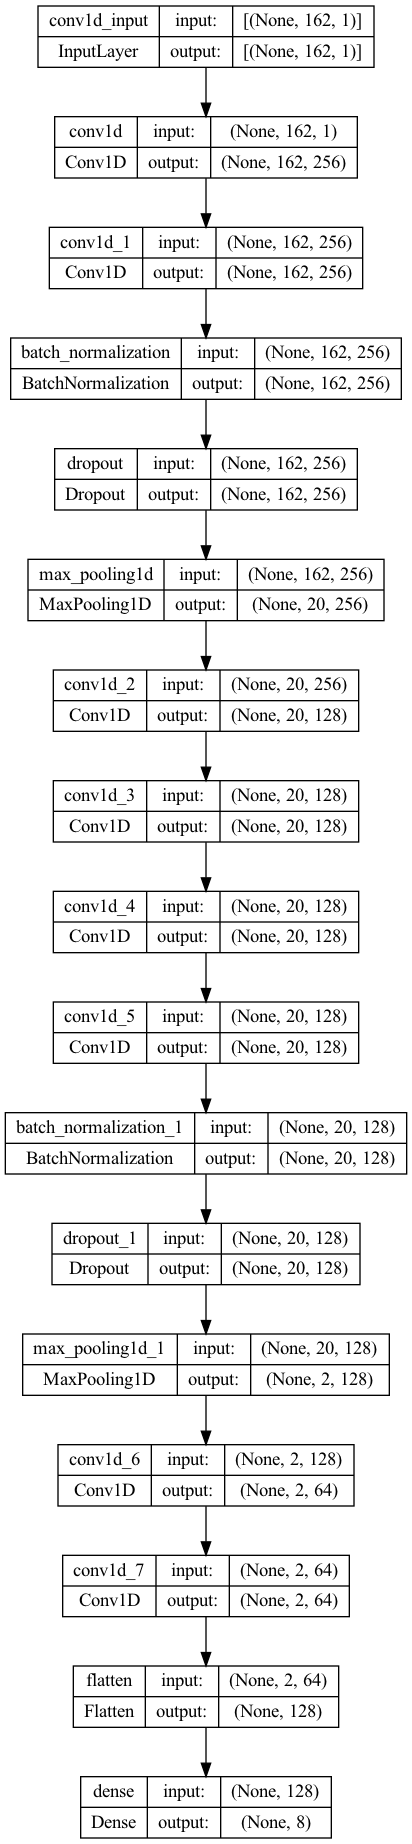

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

model = Sequential()
model.add(Conv1D(512, 8, padding='same', input_shape=(x_train.shape[1],1),activation='relu'))  # X_train.shape[1] = No. of Columns

model.add(Conv1D(256, 8, padding='same', input_shape=(x_train.shape[1],1),activation='relu'))  # X_train.shape[1] = No. of Columns
model.add(Conv1D(256, 8, padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(64, 8, padding='same',activation='relu'))
model.add(Conv1D(64, 8, padding='same',activation='relu'))
model.add(Flatten())

model.add(Dense(y_train.shape[1],activation='softmax')) # Target class number
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()